# Self-Driving Car Engineer Nanodegree


## Project 5: Vehicle Detection and Tracking


---
## Step 0: Import Libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

---

## Step 1: User Variables


In [2]:
ENABLE_CAMERA_CALIBRATION = True #enable the camera calibration process

----

## Step 2: Functions definition for lane line detection


In [3]:
def CameraObjectsAndPoints(images,nx,ny):
    # Prepare object points
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinates

    for fname in images:
        print(fname)
        #Read each image
        img =mpimg.imread(fname)

        #Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        #Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        print('Ret=',ret)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #draw and display the corners
            img = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            plt.figure()
            plt.imshow(img)

    return objpoints,imgpoints


def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def CreateBinaryImage(img,thresh_min,thresh_max,s_thresh_min,s_thresh_max):

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel s
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold color channel l
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1)& (l_binary ==1)) | (sxbinary == 1)] = 1

    return color_binary,combined_binary

def warp(img,scr,dest):
    #Image size
    img_size = (img.shape[1], img.shape[0])
    
    #Perspective transformation
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def unwarp(img,scr,dest):
    #Image size
    img_size = (img.shape[1], img.shape[0])
    
    #Perspective anti-transformation
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp the image
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped

def fillRoad(img,left_fitx,right_fitx,ploty):
    window_img = np.zeros_like(img)
    left_line= np.array([(np.transpose(np.vstack([left_fitx,ploty])))])
    right_line= np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    line_pts = np.hstack((left_line, right_line))
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    filled_img = cv2.addWeighted(img, 1, window_img, 1, 0)
    return filled_img,window_img




----

## Step 3: Camera calibration

ENABLE_CAMERA_CALIBRATION is enabled
./camera_cal\calibration1.jpg
Ret= False
./camera_cal\calibration10.jpg
Ret= True
./camera_cal\calibration11.jpg
Ret= True
./camera_cal\calibration12.jpg
Ret= True
./camera_cal\calibration13.jpg
Ret= True
./camera_cal\calibration14.jpg
Ret= True
./camera_cal\calibration15.jpg
Ret= True
./camera_cal\calibration16.jpg
Ret= True
./camera_cal\calibration17.jpg
Ret= True
./camera_cal\calibration18.jpg
Ret= True
./camera_cal\calibration19.jpg
Ret= True
./camera_cal\calibration2.jpg
Ret= True
./camera_cal\calibration20.jpg
Ret= True
./camera_cal\calibration3.jpg
Ret= True
./camera_cal\calibration4.jpg
Ret= False
./camera_cal\calibration5.jpg
Ret= False
./camera_cal\calibration6.jpg
Ret= True
./camera_cal\calibration7.jpg
Ret= True
./camera_cal\calibration8.jpg
Ret= True
./camera_cal\calibration9.jpg
Ret= True


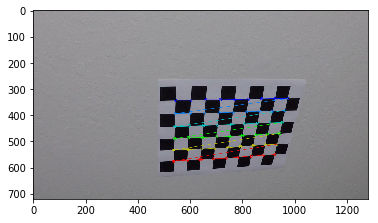

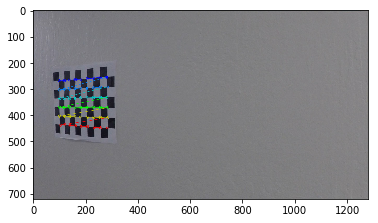

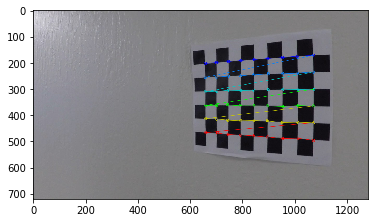

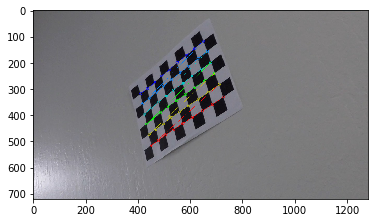

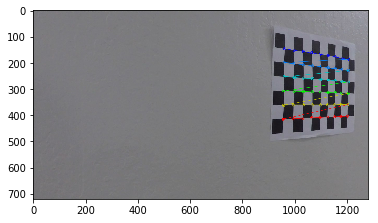

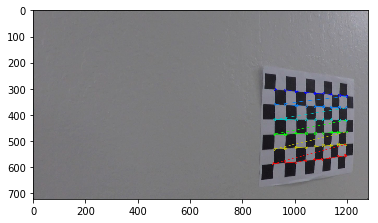

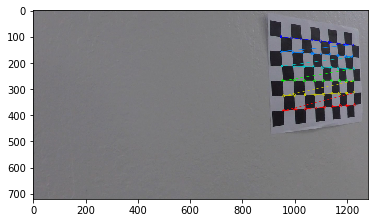

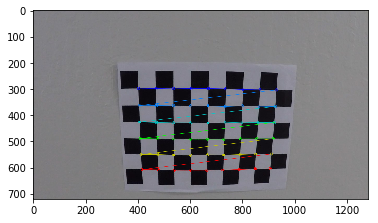

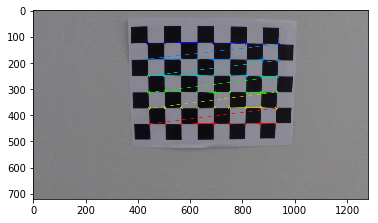

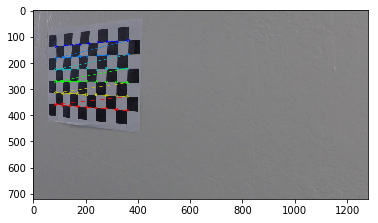

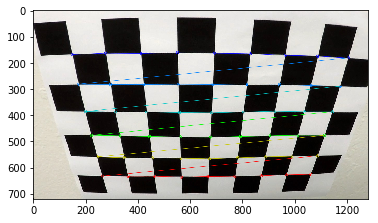

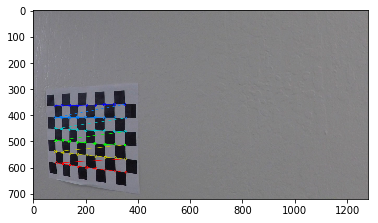

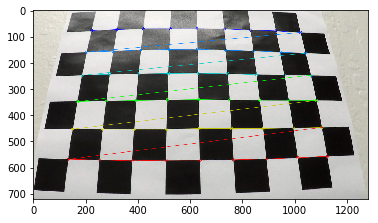

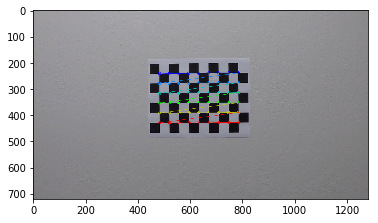

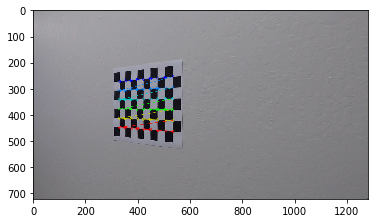

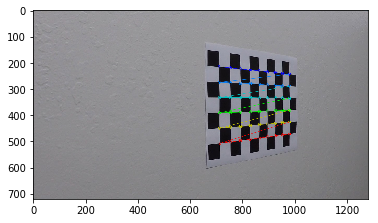

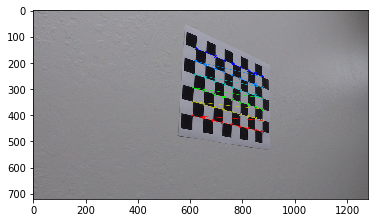

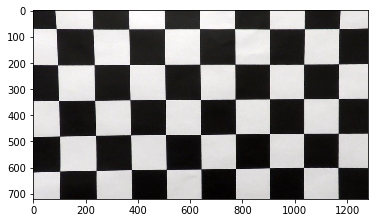

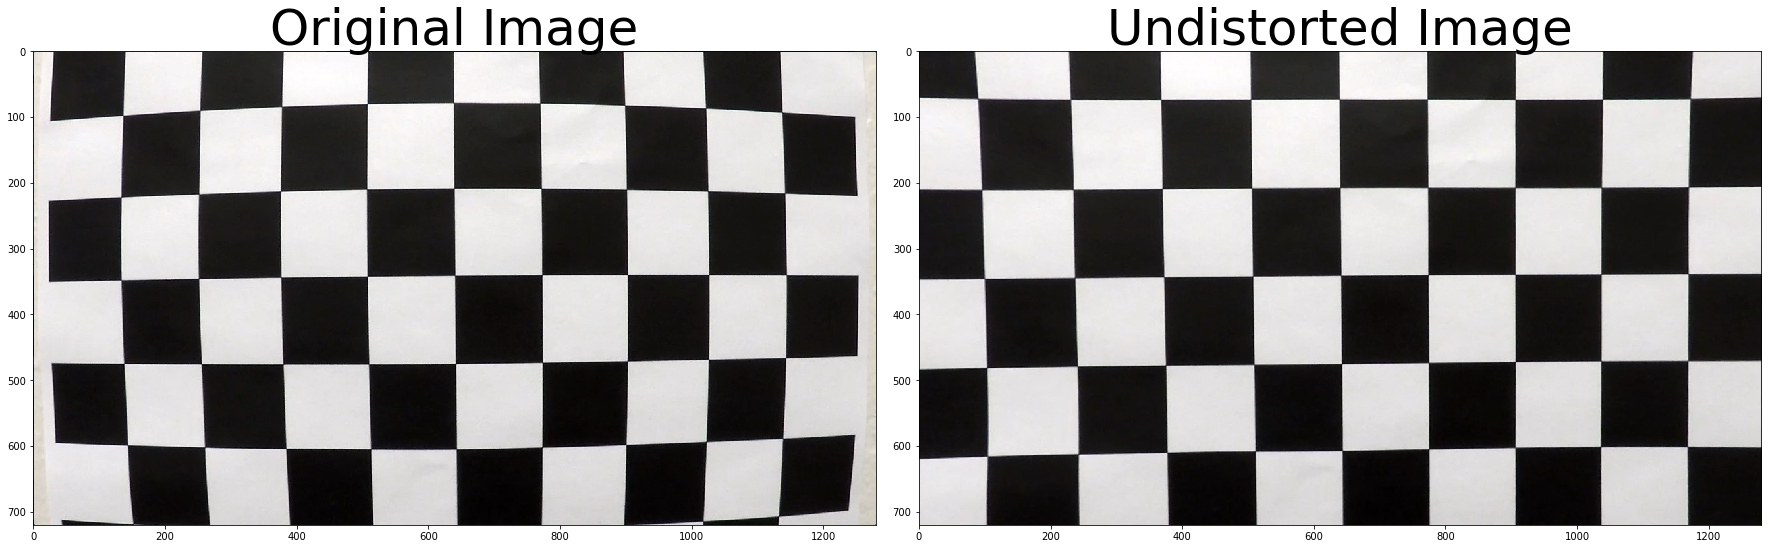

In [4]:
if ENABLE_CAMERA_CALIBRATION == True:
    print('ENABLE_CAMERA_CALIBRATION is enabled')
    #Read in a calibration image
    original_images = glob.glob('./camera_cal/calibration*.jpg')
    #Number of row and coluns in the chess board
    nx = 9
    ny = 6

    #Shape of the image
    img_sample = mpimg.imread(original_images[0])
    shapeImg = img_sample.shape

    #Calibrate the camera
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane
    objpoints,imgpoints = CameraObjectsAndPoints(original_images,nx,ny)
     #undistorT a test image
    undistorted = cal_undistort(img_sample,objpoints,imgpoints)
    plt.figure()
    plt.imshow(undistorted)

    #Show the image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_sample)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
else: 
    print('ENABLE_CAMERA_CALIBRATION is disabled')
    

   

### Test the udistortion in other images

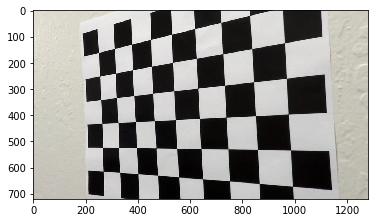

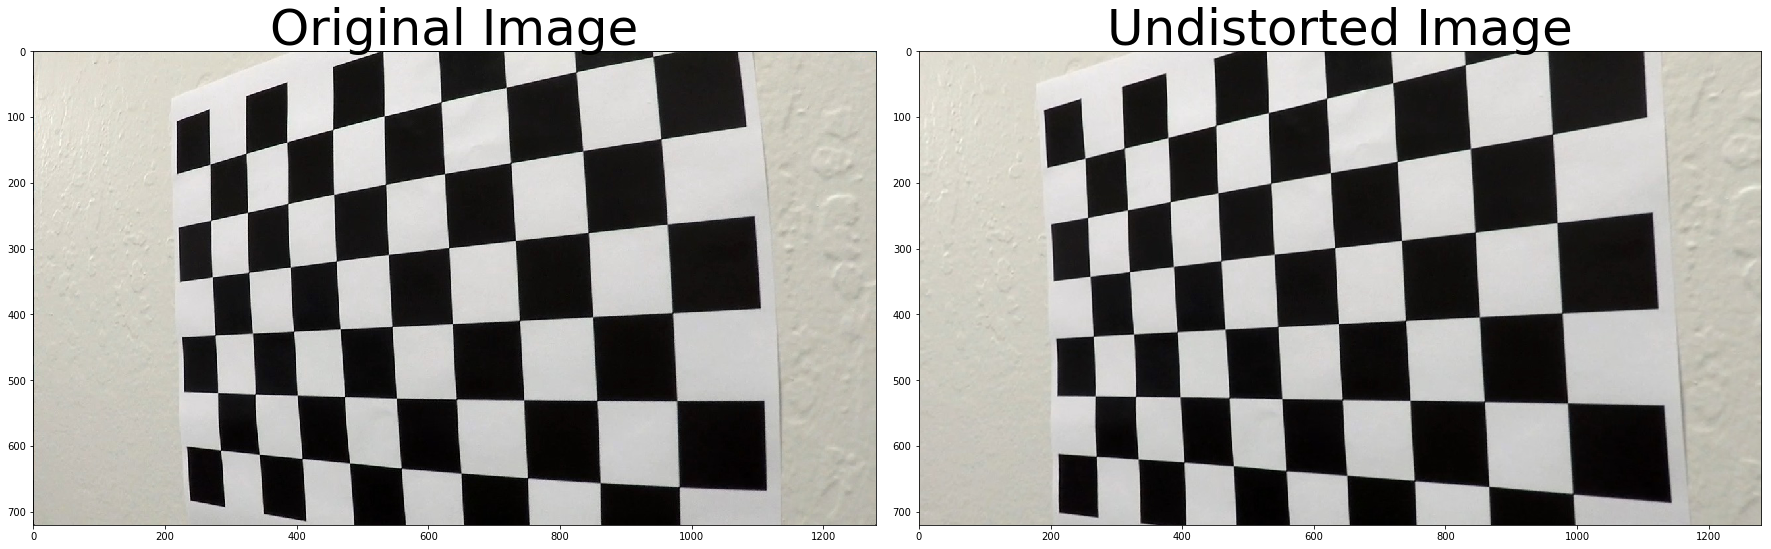

In [5]:
#Shape of the image
img_sample = mpimg.imread(original_images[14])

#Undistort a test image
undistorted = cal_undistort(img_sample,objpoints,imgpoints)
plt.imshow(undistorted)

#Show the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_sample)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---

## Step 4: Creating binary images

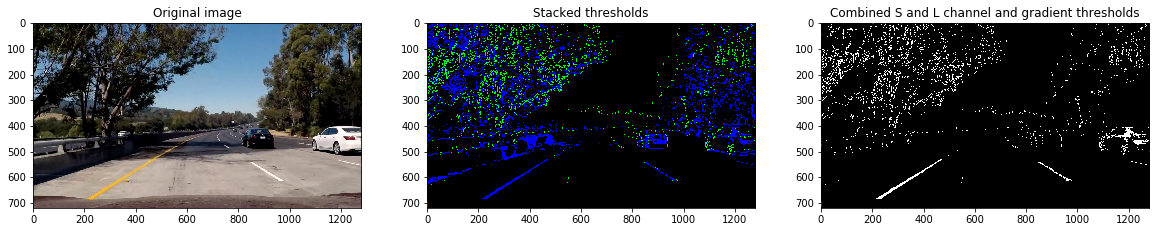

In [6]:

#Read the image tests
testPath = './/test_images/test5.jpg'
img = mpimg.imread(testPath)

#Undistort the image
undist = cal_undistort(img,objpoints,imgpoints)

#Define thresholds max and min for binary image construction
l_thresh_min = 90
l_thresh_max = 255
thresh_min = 45
thresh_max = 100
s_thresh_min = 170
s_thresh_max = 255
#Creating binary image
color_binary,combined_binary =CreateBinaryImage(img,thresh_min,thresh_max,s_thresh_min,s_thresh_max)

# Plotting thresholded images
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Original image')
ax1.imshow(img)

ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)

ax3.set_title('Combined S and L channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')

---

## Step 5: Perspective transforming

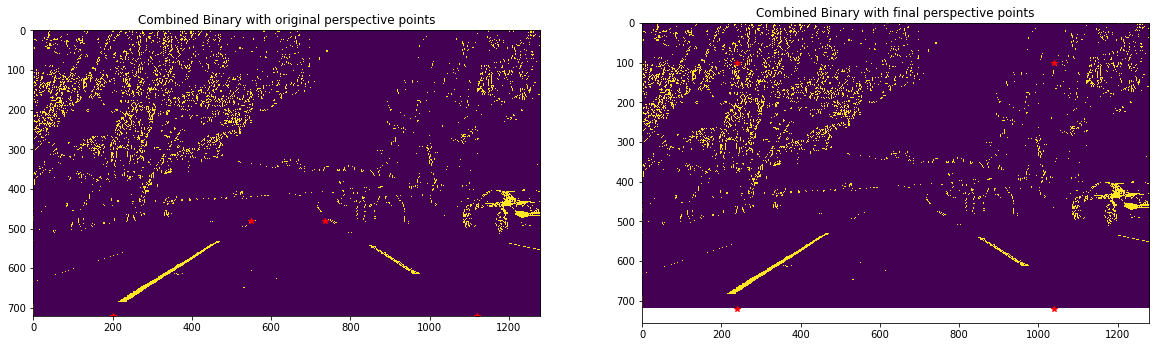

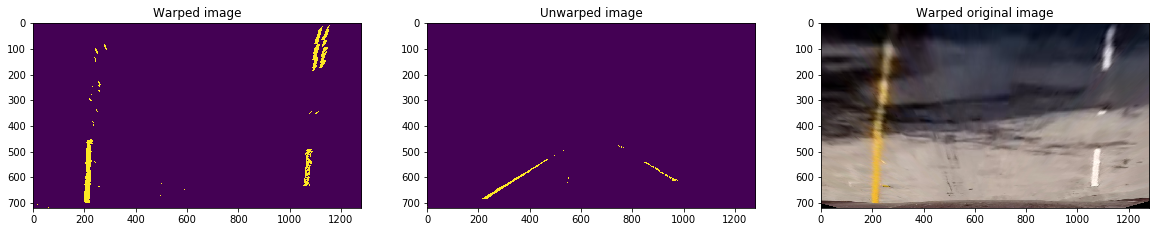

In [7]:
#Source coordinates
src1 = [200,combined_binary.shape[0]]
src2 = [550,480]
src3 = [735,480]
src4 = [1120,combined_binary.shape[0]]
src = np.float32([src1,src2,src3,src4])

#Destination coordinates
offset = 400
dst1 =[combined_binary.shape[1]/2-offset,combined_binary.shape[0]]
dst2 = [combined_binary.shape[1]/2-offset,100]
dst3 = [combined_binary.shape[1]/2+offset,100]
dst4 = [combined_binary.shape[1]/2+offset,combined_binary.shape[0]]
dst = np.float32([dst1,dst2,dst3,dst4])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Combined Binary with original perspective points')
ax1.plot(200,combined_binary.shape[0],'*r')
ax1.plot(550,480,'*r')
ax1.plot(735,480,'*r')
ax1.plot(1120,combined_binary.shape[0],'*r')
ax1.imshow(combined_binary)

ax2.set_title('Combined Binary with final perspective points')
ax2.imshow(combined_binary)
ax2.plot(combined_binary.shape[1]/2-offset,combined_binary.shape[0],'*r')
ax2.plot(combined_binary.shape[1]/2-offset,100,'*r')
ax2.plot(combined_binary.shape[1]/2+offset,100,'*r')
ax2.plot(combined_binary.shape[1]/2+offset,combined_binary.shape[0],'*r')

#warp the image
warped = warp(combined_binary,src,dst)
warped_org = warp(img,src,dst)
unwarped = unwarp(warped,src,dst)
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Warped image')
ax1.imshow(warped)
ax2.set_title('Unwarped image')
ax2.imshow(unwarped)

ax3.set_title('Warped original image')
ax3.imshow(warped_org)
    

---

## Step 6: Find Lines

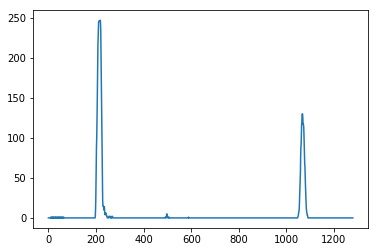

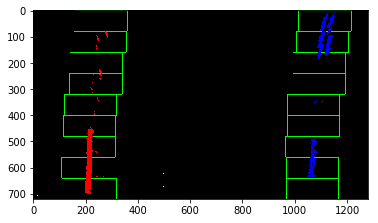

In [8]:
def findLaneLines (warped ,nwindows,margin,minpix,ym_per_pix,xm_per_pix ,enablePlot = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
    

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if (rightx_base <850):
        # Take a histogram of the up half of the image
        histogram = np.sum(warped[:warped.shape[0]//2,:], axis=0)    
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint  

    if (leftx_base >500):
        # Take a histogram of the up half of the image
        histogram = np.sum(warped[:warped.shape[0]//2,:], axis=0)
        leftx_base = np.argmax(histogram[:midpoint]) + midpoint 
    if  enablePlot == True:
        plt.plot(histogram)

    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit,left_fit_cr,right_fit_cr,out_img,leftx_base,rightx_base

#TEST THE FUNCTION findLaneLines

# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_fit, right_fit,left_fit_cr,right_fit_cr,out_img,leftx_base,rightx_base = findLaneLines (warped ,nwindows,margin,minpix,ym_per_pix,xm_per_pix ,True)

plt.figure()
plt.imshow(out_img)

### Visualization

(720, 0)

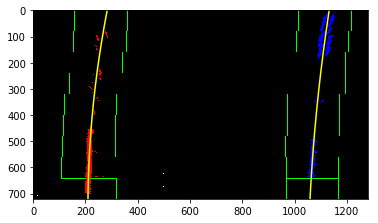

In [9]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

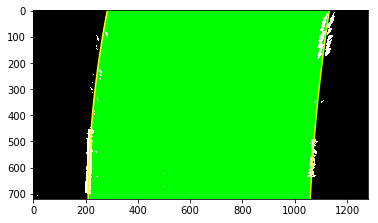

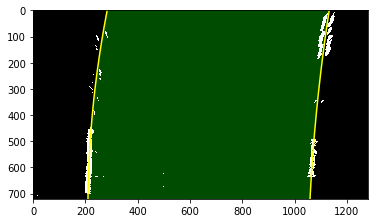

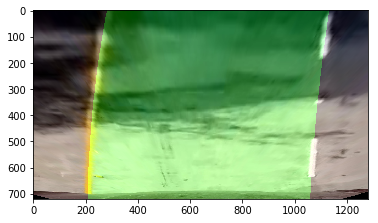

In [10]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels


# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))


filled_img,window_img = fillRoad(out_img,left_fitx,right_fitx,ploty)
#filled_img = filled_img[:,int(img.shape[1]/2-400):int(img.shape[1]/2+400)]
plt.figure()
plt.imshow( filled_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure()
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.figure()
result2 = cv2.addWeighted(warped_org, 1, window_img, 0.3, 0)
plt.imshow(result2)


### Calculation of the radius

In [11]:
def calculateRadius(warped,left_fit,right_fit,ym_per_pix):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
   
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*ym_per_pix*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])

    right_curverad = ((1 + (2*right_fit[0]*ym_per_pix*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad,right_curverad

left_curverad, right_curverad = calculateRadius(warped,left_fit_cr,right_fit_cr,ym_per_pix)
print(left_curverad, right_curverad)


1293.13636813 2335.19066809


### Calculation of the Position

In [12]:
def calculatePositions(leftx_base,rightx_base,img_shape,xm_per_pix):
    center_img = img_shape[1]/2
    center_vehicle = (leftx_base + rightx_base)/2
    position = xm_per_pix*(center_img-center_vehicle)
    
    return position

position = calculatePositions(leftx_base,rightx_base,out_img.shape,xm_per_pix)
print(position)
if position<0:
    print("left")
else:
    print("right")

-0.0132142857143
left



---

## Step 7: Test on the video

In [33]:
#Read the frames of the video
VideoPath = './project_video.mp4'
video = cv2.VideoCapture(VideoPath)

ret, frame =video.read()
#MOSTRAR RESUMO DO VIDEO
print("===========================================================")
print("Frame Shape:",frame.shape)
TotalFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total de frames:",TotalFrames)
print("FPS: ",int(video.get(cv2.CAP_PROP_FPS)))
print("===========================================================")


#name of the output video
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_out =cv2.VideoWriter('result4.mp4',fourcc,video.get(cv2.CAP_PROP_FPS), (frame.shape[1],frame.shape[0]))

#Define thresholds max and min for binary image construction
thresh_min = 45
thresh_max = 100
s_thresh_min = 170
s_thresh_max = 255

# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
countFrames = 0 
ENABLE_PLOT = False

while(ret == True):
    
    
    #Undistort the image
    undist = cal_undistort(frame,objpoints,imgpoints)
    
    #Creating binary image
    color_binary,combined_binary =CreateBinaryImage(undist,thresh_min,thresh_max,s_thresh_min,s_thresh_max)
    
    #warp the image
    warped = warp(combined_binary,src,dst)
   
    #warp the image original
    warped_original = warp(frame,src,dst)
    
    #find lane lines
    left_fit, right_fit,left_fit_cr,right_fit_cr,out_img,leftx_base,rightx_base = findLaneLines (warped ,nwindows,margin,minpix,ym_per_pix,xm_per_pix)

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    #fill the road detection
    filled_img,window_img = fillRoad(warped_original,left_fitx,right_fitx,ploty)
    
    
    
    #Unwarp the image
    frame_out = frame.copy()
    unwarped = unwarp(window_img,src,dst)
    frame_out[unwarped.nonzero()] +=100
    
    #calulate the radius
    left_curverad, right_curverad = calculateRadius(warped,left_fit,right_fit,ym_per_pix)
    
    #calculate the position
    position = calculatePositions(leftx_base,rightx_base,out_img.shape,xm_per_pix)
    
    if position<0:
        pos = "left"
    else:
        pos = "right"
    position = np.absolute(position)
    #write the radius on the frame
    cv2.putText(frame_out,str("Radius of curvature: ")+str(round(left_curverad,2))+str("m"),(100,100), cv2.FONT_HERSHEY_DUPLEX,1.5, (255, 0, 0))
    cv2.putText(frame_out,str("Vehicle is ") + str(round(position,2))+str("m to the ")+ pos+str(" of center"),(100,200), cv2.FONT_HERSHEY_DUPLEX,1.5, (255, 0, 0))
    video_out.write(frame_out)

    countFrames = countFrames +1
    print(str(countFrames),"/",str(TotalFrames))
    
    
    if ENABLE_PLOT == True:
        
        #Original image
        plt.figure()
        plt.imshow(frame)
        
        #Undistorted image
        plt.figure()
        plt.imshow( undist)
        
        #Binary image
        plt.figure()
        plt.imshow( combined_binary)
        
        #Warp binary image
        plt.figure()
        plt.imshow( warped)
        
        #Warp original image
        plt.figure()
        plt.imshow( warped_original)
        
        #Lane Line detection
        plt.figure()
        plt.imshow(out_img)
        
        #Road detection
        plt.figure()
        plt.imshow(filled_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        #Undistort image
        plt.figure()
        plt.imshow(unwarped)
        
        #Undistort image
        plt.figure()
        plt.imshow(frame_out)
        
        #limit the quantity of images to be ploted
        if (countFrames >0):
            break
            
    #read next frame
    ret, frame =video.read()
    
    
#Save the video
video_out.release() 
video.release()


Frame Shape: (720, 1280, 3)
Total de frames: 1260
FPS:  25
1 / 1260
2 / 1260
3 / 1260
4 / 1260
5 / 1260
6 / 1260
7 / 1260
8 / 1260
9 / 1260
10 / 1260
11 / 1260
12 / 1260
13 / 1260
14 / 1260
15 / 1260
16 / 1260
17 / 1260
18 / 1260
19 / 1260
20 / 1260
21 / 1260
22 / 1260
23 / 1260
24 / 1260
25 / 1260
26 / 1260
27 / 1260
28 / 1260
29 / 1260
30 / 1260
31 / 1260
32 / 1260
33 / 1260
34 / 1260
35 / 1260
36 / 1260
37 / 1260
38 / 1260
39 / 1260
40 / 1260
41 / 1260
42 / 1260
43 / 1260
44 / 1260
45 / 1260
46 / 1260
47 / 1260
48 / 1260
49 / 1260
50 / 1260
51 / 1260
52 / 1260
53 / 1260
54 / 1260
55 / 1260
56 / 1260
57 / 1260
58 / 1260
59 / 1260
60 / 1260
61 / 1260
62 / 1260
63 / 1260
64 / 1260
65 / 1260
66 / 1260
67 / 1260
68 / 1260
69 / 1260
70 / 1260
71 / 1260
72 / 1260
73 / 1260
74 / 1260
75 / 1260
76 / 1260
77 / 1260
78 / 1260
79 / 1260
80 / 1260
81 / 1260
82 / 1260
83 / 1260
84 / 1260
85 / 1260
86 / 1260
87 / 1260
88 / 1260
89 / 1260
90 / 1260
91 / 1260
92 / 1260
93 / 1260
94 / 1260
95 / 1260


740 / 1260
741 / 1260
742 / 1260
743 / 1260
744 / 1260
745 / 1260
746 / 1260
747 / 1260
748 / 1260
749 / 1260
750 / 1260
751 / 1260
752 / 1260
753 / 1260
754 / 1260
755 / 1260
756 / 1260
757 / 1260
758 / 1260
759 / 1260
760 / 1260
761 / 1260
762 / 1260
763 / 1260
764 / 1260
765 / 1260
766 / 1260
767 / 1260
768 / 1260
769 / 1260
770 / 1260
771 / 1260
772 / 1260
773 / 1260
774 / 1260
775 / 1260
776 / 1260
777 / 1260
778 / 1260
779 / 1260
780 / 1260
781 / 1260
782 / 1260
783 / 1260
784 / 1260
785 / 1260
786 / 1260
787 / 1260
788 / 1260
789 / 1260
790 / 1260
791 / 1260
792 / 1260
793 / 1260
794 / 1260
795 / 1260
796 / 1260
797 / 1260
798 / 1260
799 / 1260
800 / 1260
801 / 1260
802 / 1260
803 / 1260
804 / 1260
805 / 1260
806 / 1260
807 / 1260
808 / 1260
809 / 1260
810 / 1260
811 / 1260
812 / 1260
813 / 1260
814 / 1260
815 / 1260
816 / 1260
817 / 1260
818 / 1260
819 / 1260
820 / 1260
821 / 1260
822 / 1260
823 / 1260
824 / 1260
825 / 1260
826 / 1260
827 / 1260
828 / 1260
829 / 1260
830 / 1260

In [ ]:
#Unwarp the image
unwarped = unwarp(window_img,src,dst)

#Undistort image
plt.figure()
plt.imshow(unwarped)
frame2 = frame.copy()
frame2[unwarped.nonzero()] +=100
print(frame[unwarped.nonzero()].shape)
plt.figure()
#cv2.putText(frame2,str(left_curverad),(int(frame_out.shape[1]*0.65),int(frame_out.shape[0]*0.1)), cv2.FONT_HERSHEY_DUPLEX,1000, (255, 0, 0))


plt.imshow(frame2)

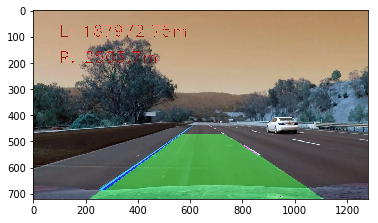

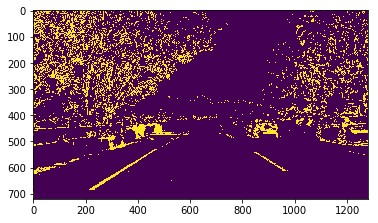

In [39]:
VideoPath = '../result3.mp4'
video = cv2.VideoCapture(VideoPath)


Numframe = 500
video.set(cv2.CAP_PROP_POS_FRAMES,Numframe)
ret, frame =video.read()
#Define thresholds max and min for binary image construction
l_thresh_min = 0
l_thresh_max = 255
thresh_min = 45
thresh_max = 100
s_thresh_min = 170
s_thresh_max = 255
#Creating binary image
color_binary,combined_binary =CreateBinaryImage(img,thresh_min,thresh_max,s_thresh_min,s_thresh_max)
plt.figure()
plt.imshow(frame)
plt.figure()
plt.imshow(combined_binary)


In [35]:
combined_binary.shape

(720, 1280)

In [36]:
720/2


360.0

In [37]:
1280/2-400

240.0